# Analysis of Lexical features
***

## Workflow:
1. Imports the labels and features
2. Preprocessing and joining dataframes
3. Sentiment score analysis
4. Simple word count feature analysis
5. LIWC analysis
6. Save for dashboard and create figures for all interviews

# 1. Import data

- Labels
- Sentiments
- Liwc
- Word count like features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import statistics 
import scipy

import warnings

In [ ]:
labels = pd.read_csv('drive/MyDrive/Colab Notebooks/XAI/datasets/turker_scores_full_interview.csv')

index_names = labels[labels['Worker'] != 'AGGR' ].index
labels = labels.drop(index_names)
labels = labels.drop(['Worker'], axis=1)


In [ ]:
sentiments = pd.read_csv('drive/MyDrive/Colab Notebooks/XAI/datasets/MIT_dataset_emotion_prediction.csv')
sentiments = sentiments.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [ ]:
simple_features = pd.read_csv('drive/MyDrive/Colab Notebooks/XAI/datasets/wordcount_uniquewordcount.csv')
simple_features = simple_features.rename(columns = {'Person':'Participant'})

In [ ]:
def change_numeric(string):
    if isinstance(string, str):
        if not ('p' in string):
            return pd.to_numeric(string.replace(',','.'))
        else:
            return string
    else:
        return string

In [ ]:
liwc = pd.read_csv('drive/MyDrive/Colab Notebooks/XAI/datasets/handcrafted_lexical_features.csv')
liwc = liwc.rename(columns = {'Person':'Participant'})
liwc = liwc.drop(['text_unprocessed', 'tokenize', 'stemming', 'interview_length', 'wc', 'wps', 'uwc', 'uwps'], axis=1)
liwc = liwc.drop(['i', 'we', 'you_total', 'you_sing', 'you_plur', 'you_formal', 'Authentic', 'they', 'compare', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Parenth'], axis=1)
liwc = liwc.applymap(change_numeric)

# 2. Preprocessing and joining dataframes

In [ ]:
def predictions_2_counts (prediction_list):
  out =	{
    'neutral': prediction_list.count('neutral'),
    'joy': prediction_list.count('joy'),
    'anger': prediction_list.count('anger'),
    'fear':prediction_list.count('fear'),
    'sadness': prediction_list.count('sadness')
  }
  return out
def predictions_2_percentage (number_sentences, prediction_list):
  out =	{
    'neutral': prediction_list.count('neutral') / number_sentences,
    'joy': prediction_list.count('joy') / number_sentences,
    'anger': prediction_list.count('anger') / number_sentences,
    'fear':prediction_list.count('fear') / number_sentences,
    'sadness': prediction_list.count('sadness') / number_sentences
  }
  return out

In [ ]:
# preprocessing
sentiments['tokenize_sentence'] = sentiments['tokenize_sentence'].apply(literal_eval)
sentiments['prediction'] = sentiments['prediction'].apply(literal_eval)
sentiments['number_sentences'] = sentiments['tokenize_sentence'].apply(len)
sentiments['count_prediction'] = sentiments['prediction'].apply(predictions_2_counts)
sentiments['percentage_prediction'] = sentiments[['number_sentences', 'prediction']].apply(lambda x: predictions_2_percentage(*x), axis = 1)

# joining
df = sentiments.merge(labels, on='Participant', validate='one_to_one')
df = df.merge(simple_features, on='Participant', validate='one_to_one')
df = df.merge(liwc, on='Participant', validate='one_to_one')
df = df.drop(['text_remove_interview_signs', 'tokenize_sentence', 'prediction', 'number_sentences'], axis=1)
df['simple_feature_dict'] = df[['wps', 'uwps', 'wc', 'uwc']].to_dict(orient='records')
df = df.join(df['percentage_prediction'].apply(pd.Series), lsuffix='_liwc')

# 3. Sentiment analysis

In [ ]:
# define what is a good interview
index_good_interviews = df['RecommendHiring'].rank(pct=True) >= 0.8
index_bad_interviews = df['RecommendHiring'].rank(pct=True) < 0.8
# get mean and stdev for all
mean = df[index_good_interviews][['neutral', 'joy', 'anger', 'fear', 'sadness', 'wps', 'uwps', 'adj', 'adverb']].aggregate(statistics.mean)
stdev = df[index_good_interviews][['neutral', 'joy', 'anger', 'fear', 'sadness', 'wps', 'uwps', 'adj', 'adverb']].aggregate(statistics.stdev)
mean_stdev = pd.concat({'mean': mean, 'stdev': stdev}, axis=1)
# get mean and stdev in figure
def stdev_lines(emotion):
  return [mean_stdev.loc[emotion, 'mean'] + mean_stdev.loc[emotion, 'stdev'], mean_stdev.loc[emotion, 'mean'] - mean_stdev.loc[emotion, 'stdev']]

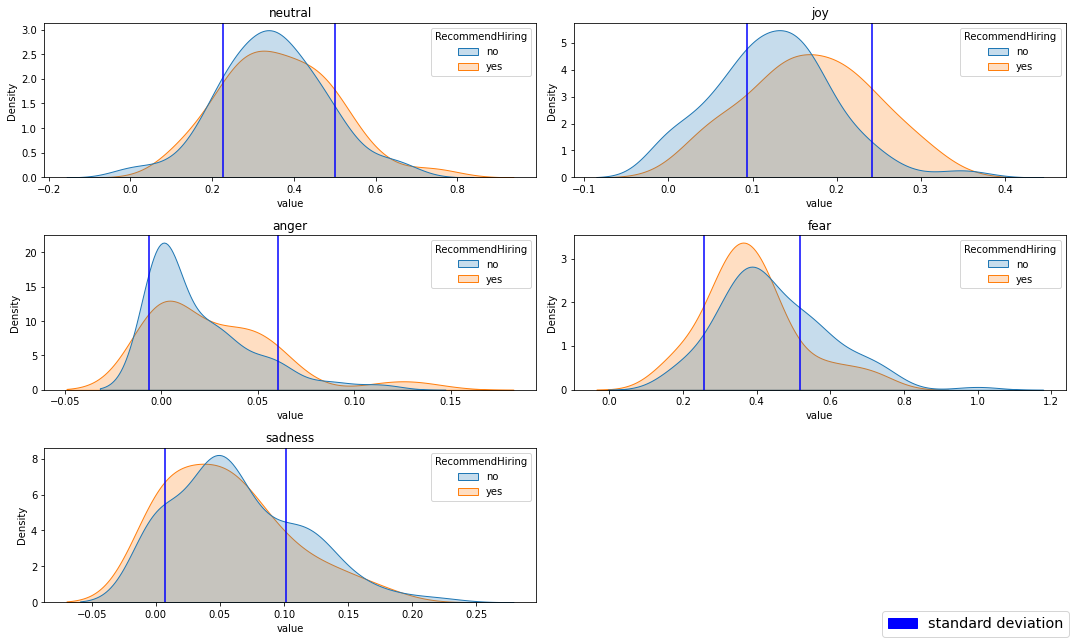

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 9))
label = 'RecommendHirring'
x = y = 0 

for name in ['neutral', 'joy', 'anger', 'sadness', 'fear']:
  sns.kdeplot(data=df[[f'{label}_split', f'{name}']], 
                  hue=f'{label}_split', x=f'{name}', ax=axes[y,x], 
                  fill=True, common_norm=False).set(title=f'BERT {name} feature predicts RecommendHirring label') 
  axes[y,x].axvline(stdev_lines(name)[0], color='blue')
  axes[y,x].axvline(stdev_lines(name)[1], color='blue')
  axes[y,x].axvline(row['percentage_prediction'].get(name), color='red')
  # update the axes for figures
  x++
  if x % 2 == 0:
    y++
    x=0

plt.delaxes(ax=axes[2, 1])
plt.tight_layout()
blue_patch = mpatches.Patch(color='blue', label='One standard devation for good interviews')
red_patch = mpatches.Patch(color='red', label='Your score')
fig.legend(handles=[blue_patch, red_patch], loc='lower right', fontsize='x-large')

**Interpretation of figures above**

In the plot above one can observe the difference between a good interview and a bad interview with respect to the sentiment scores of individual sentences.

It becomes apparent that a good interviewee used less fearful sentences and more joyful once. Which was to be expected. This in turn shows that the model learned valueable information from the real world.

However the difference between good and bad interviews is very slight. Which makes classifying interviewees based on the emotional characteristics in their sentences unfeasible.

**Check the correlation**

In [ ]:
corr_list = {}
n = df.shape[0]
for sentiment in ['anger', 'neutral', 'fear', 'joy', 'sadness']:
  s_arr = np.zeros(n)
  for i in range(n):
    s_arr[i] = ( df["percentage_prediction"].values[i][sentiment])
  corr_list[sentiment] = s_arr

corr_values = {}
for sentiment in ['anger', 'neutral', 'fear', 'joy', 'sadness']:
  data1 = corr_list[sentiment]
  df2 = df['RecommendHiring']
  df1 = pd.DataFrame(data1,columns=['value'])

  corr_values[sentiment] = scipy.stats.pearsonr(df2.values, df1.values.reshape(1,-1)[0])
corr_values

{'anger': (0.12511891782988305, 0.14368709084908382),
 'fear': (-0.09190304063464838, 0.28369002888509864),
 'joy': (0.035913480980598475, 0.6758115984439551),
 'neutral': (0.061348184929112495, 0.474734850737153),
 'sadness': (-0.018104131356560013, 0.8330759763622504)}

# 4. Simple lexical features analysis

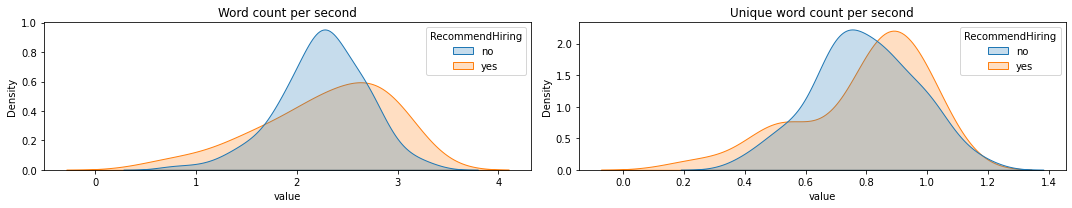

In [ ]:
  # simple_features
  fig, axes = plt.subplots(1, 2, figsize=(15, 3))

  # wcps
  name ='wps' 
  label = 'SpeakingRate'
  sns.kdeplot(data=df[[f'{label}_split', f'{name}']], 
                  hue=f'{label}_split', x=f'{name}', ax=axes[0], 
                  fill=True, common_norm=False).set(title=f'Words feature predicts SpeakingRate label') 
  axes[0].axvline(stdev_lines(name)[0], color='blue')
  axes[0].axvline(stdev_lines(name)[1], color='blue')
  axes[0].axvline(row['simple_feature_dict'].get('wps'), color='red')

  # uwcps
  name ='uwps'
  label = 'Paused'
  sns.kdeplot(data=df[[f'{label}_split', f'{name}']], 
                  hue=f'{label}_split', x=f'{name}', ax=axes[1], 
                  fill=True, common_norm=False).set(title=f'Unique words feature predicts Paused label') 
  axes[1].axvline(stdev_lines(name)[0], color='blue')
  axes[1].axvline(stdev_lines(name)[1], color='blue')
  axes[1].axvline(row['simple_feature_dict'].get('uwps'), color='red')

  plt.tight_layout()
  blue_patch = mpatches.Patch(color='blue', label='your score')
  fig.savefig(f'drive/MyDrive/Colab Notebooks/XAI/graphs/simple_features/{row.Participant}')
  plt.close()

**Check the correlation**

In [ ]:
corr_list = {}
n = df.shape[0]
for sentiment in ['wps', 'uwps', 'wc', 'uwc']:
  s_arr = np.zeros(n)
  for i in range(n):
    s_arr[i] = (df["simple_feature_dict"].values[i][sentiment])
  corr_list[sentiment] = s_arr

corr_values = {}
for sentiment in ['wps', 'uwps', 'wc', 'uwc']:
  data1 = corr_list[sentiment]
  df2 = df['RecommendHiring']
  df1 = pd.DataFrame(data1,columns=['value'])


  corr_values[sentiment] = scipy.stats.pearsonr(df2.values, df1.values.reshape(1,-1)[0])

corr_values

{'uwc': (0.2354529975298595, 0.005436176289592605),
 'uwps': (0.09095908427459508, 0.2886857063944745),
 'wc': (0.18644255956764846, 0.02855922445688121),
 'wps': (0.20146741821005218, 0.017810760534798846)}

# 6. LIWC


In the paper Automated Analysis and Prediction of Job Interview Performance they used the following features from the LIWC2007 analysis (https://roc-hci.com/wp-content/uploads/tac16_job.pdf).

Categories: I, We, They, Non-fluencies, PosEmotion, NegEmotion, Anxiety, Anger, Sadness, Cognitive, Inhibition, Perceptual, Relativity, Work, Swear, Articles, Verbs, Adverbs, Prepositions, Conjunctions, Negations, Quantifiers, Numbers

They applied a greedy backward elimination feature selection algorithm to get to these most important features.

Inhibition is not available anymore


In [ ]:
df['combined_filler_nonflu'] = df['filler'] + df['nonflu']

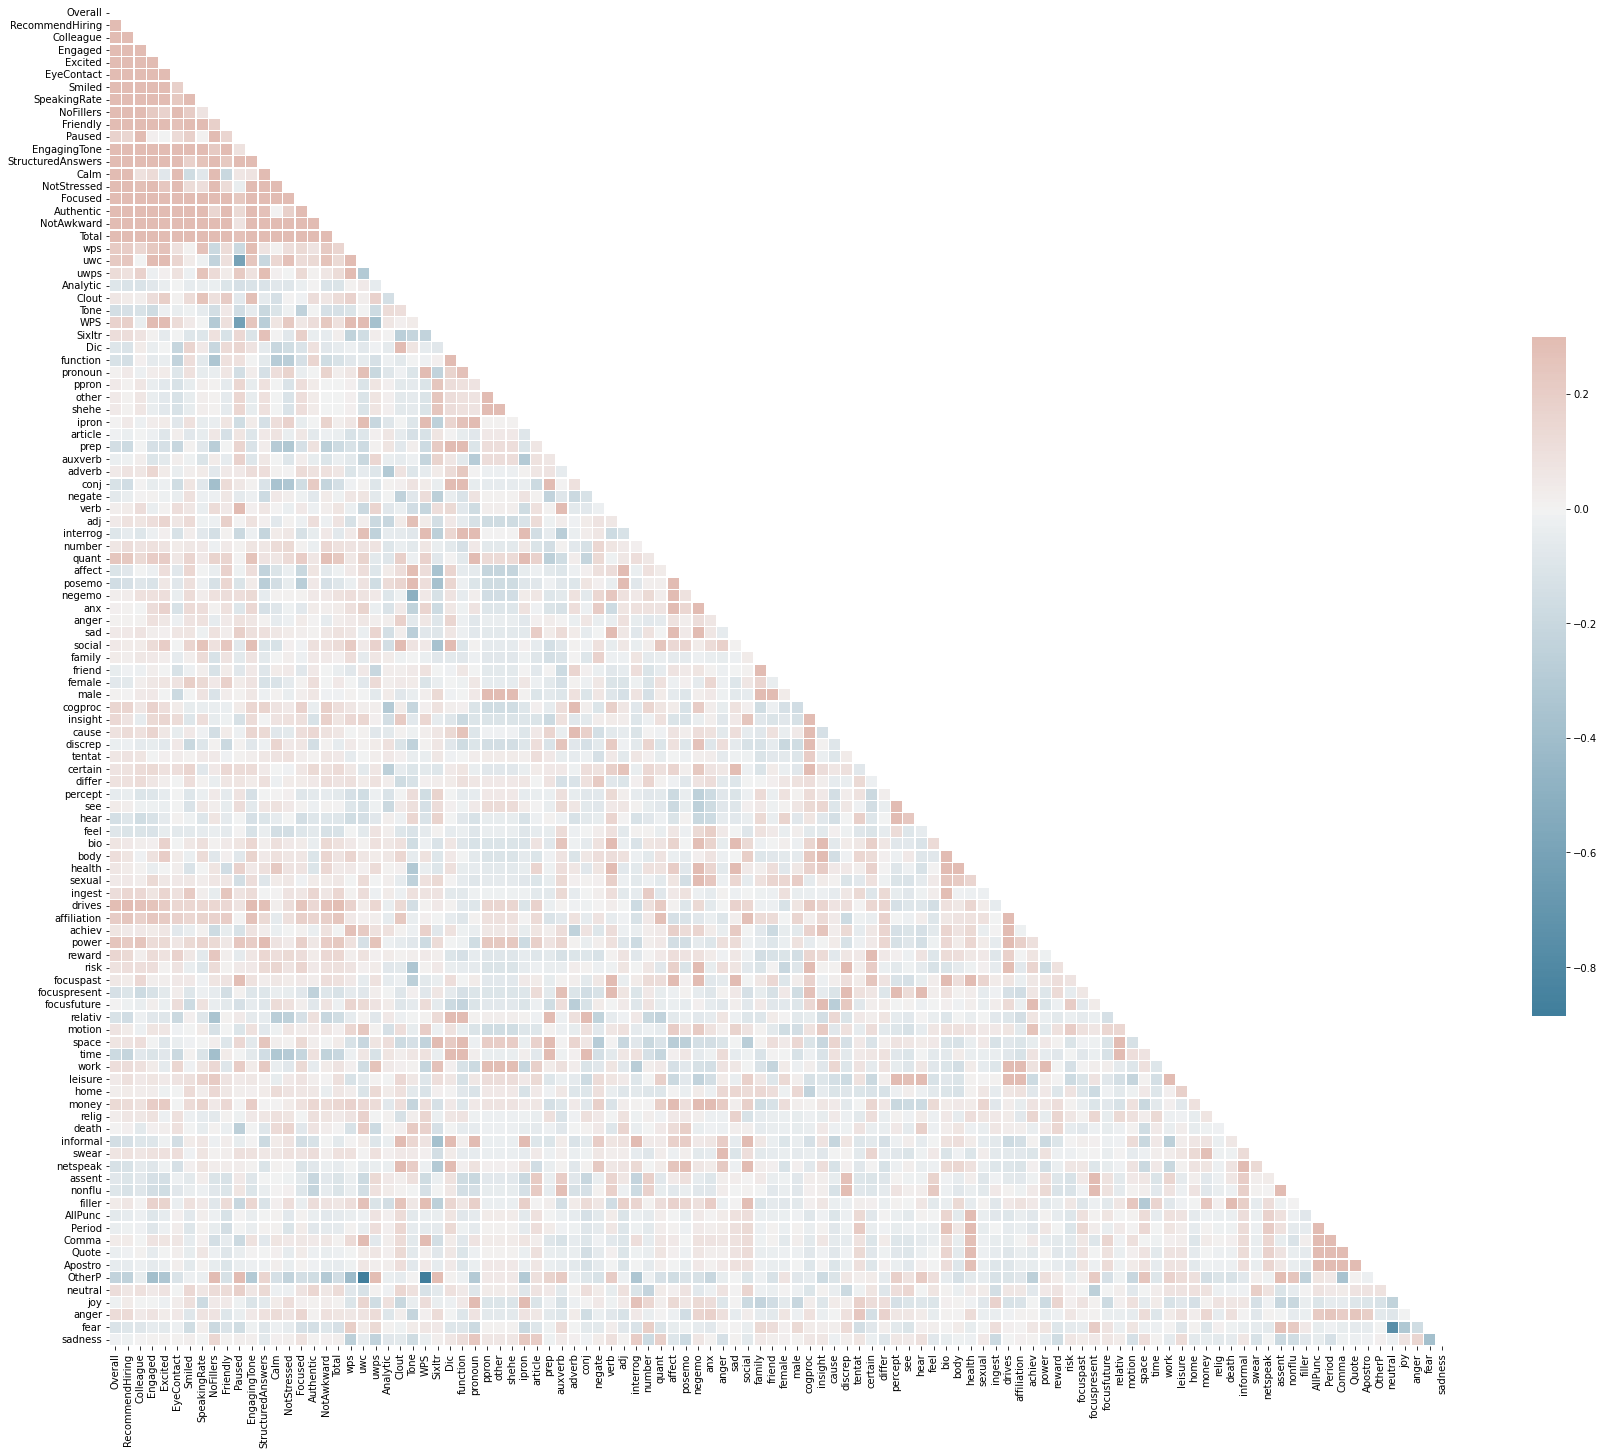

In [ ]:
# Compute the correlation matrix
corr = df.iloc[:,7:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

[Text(0.5, 1.0, 'Positive Emotions LIWC')]

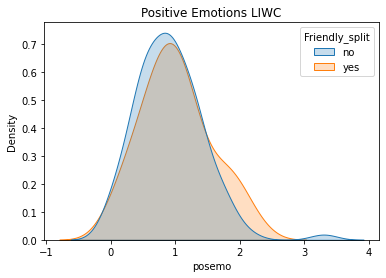

In [ ]:
df['Friendly_split'] = pd.qcut(df['Friendly'], [0, 0.749, 0.75, 1], labels=['no', 'drop', 'yes'])
a = df[['Friendly_split', 'posemo']][df.Friendly_split != 'drop'].reset_index(drop=True)
a['Friendly_split'] = a['Friendly_split'].astype('str')
sns.kdeplot(data=a, hue='Friendly_split', x='posemo', fill=True, common_norm=False).set(title='Positive Emotions LIWC')

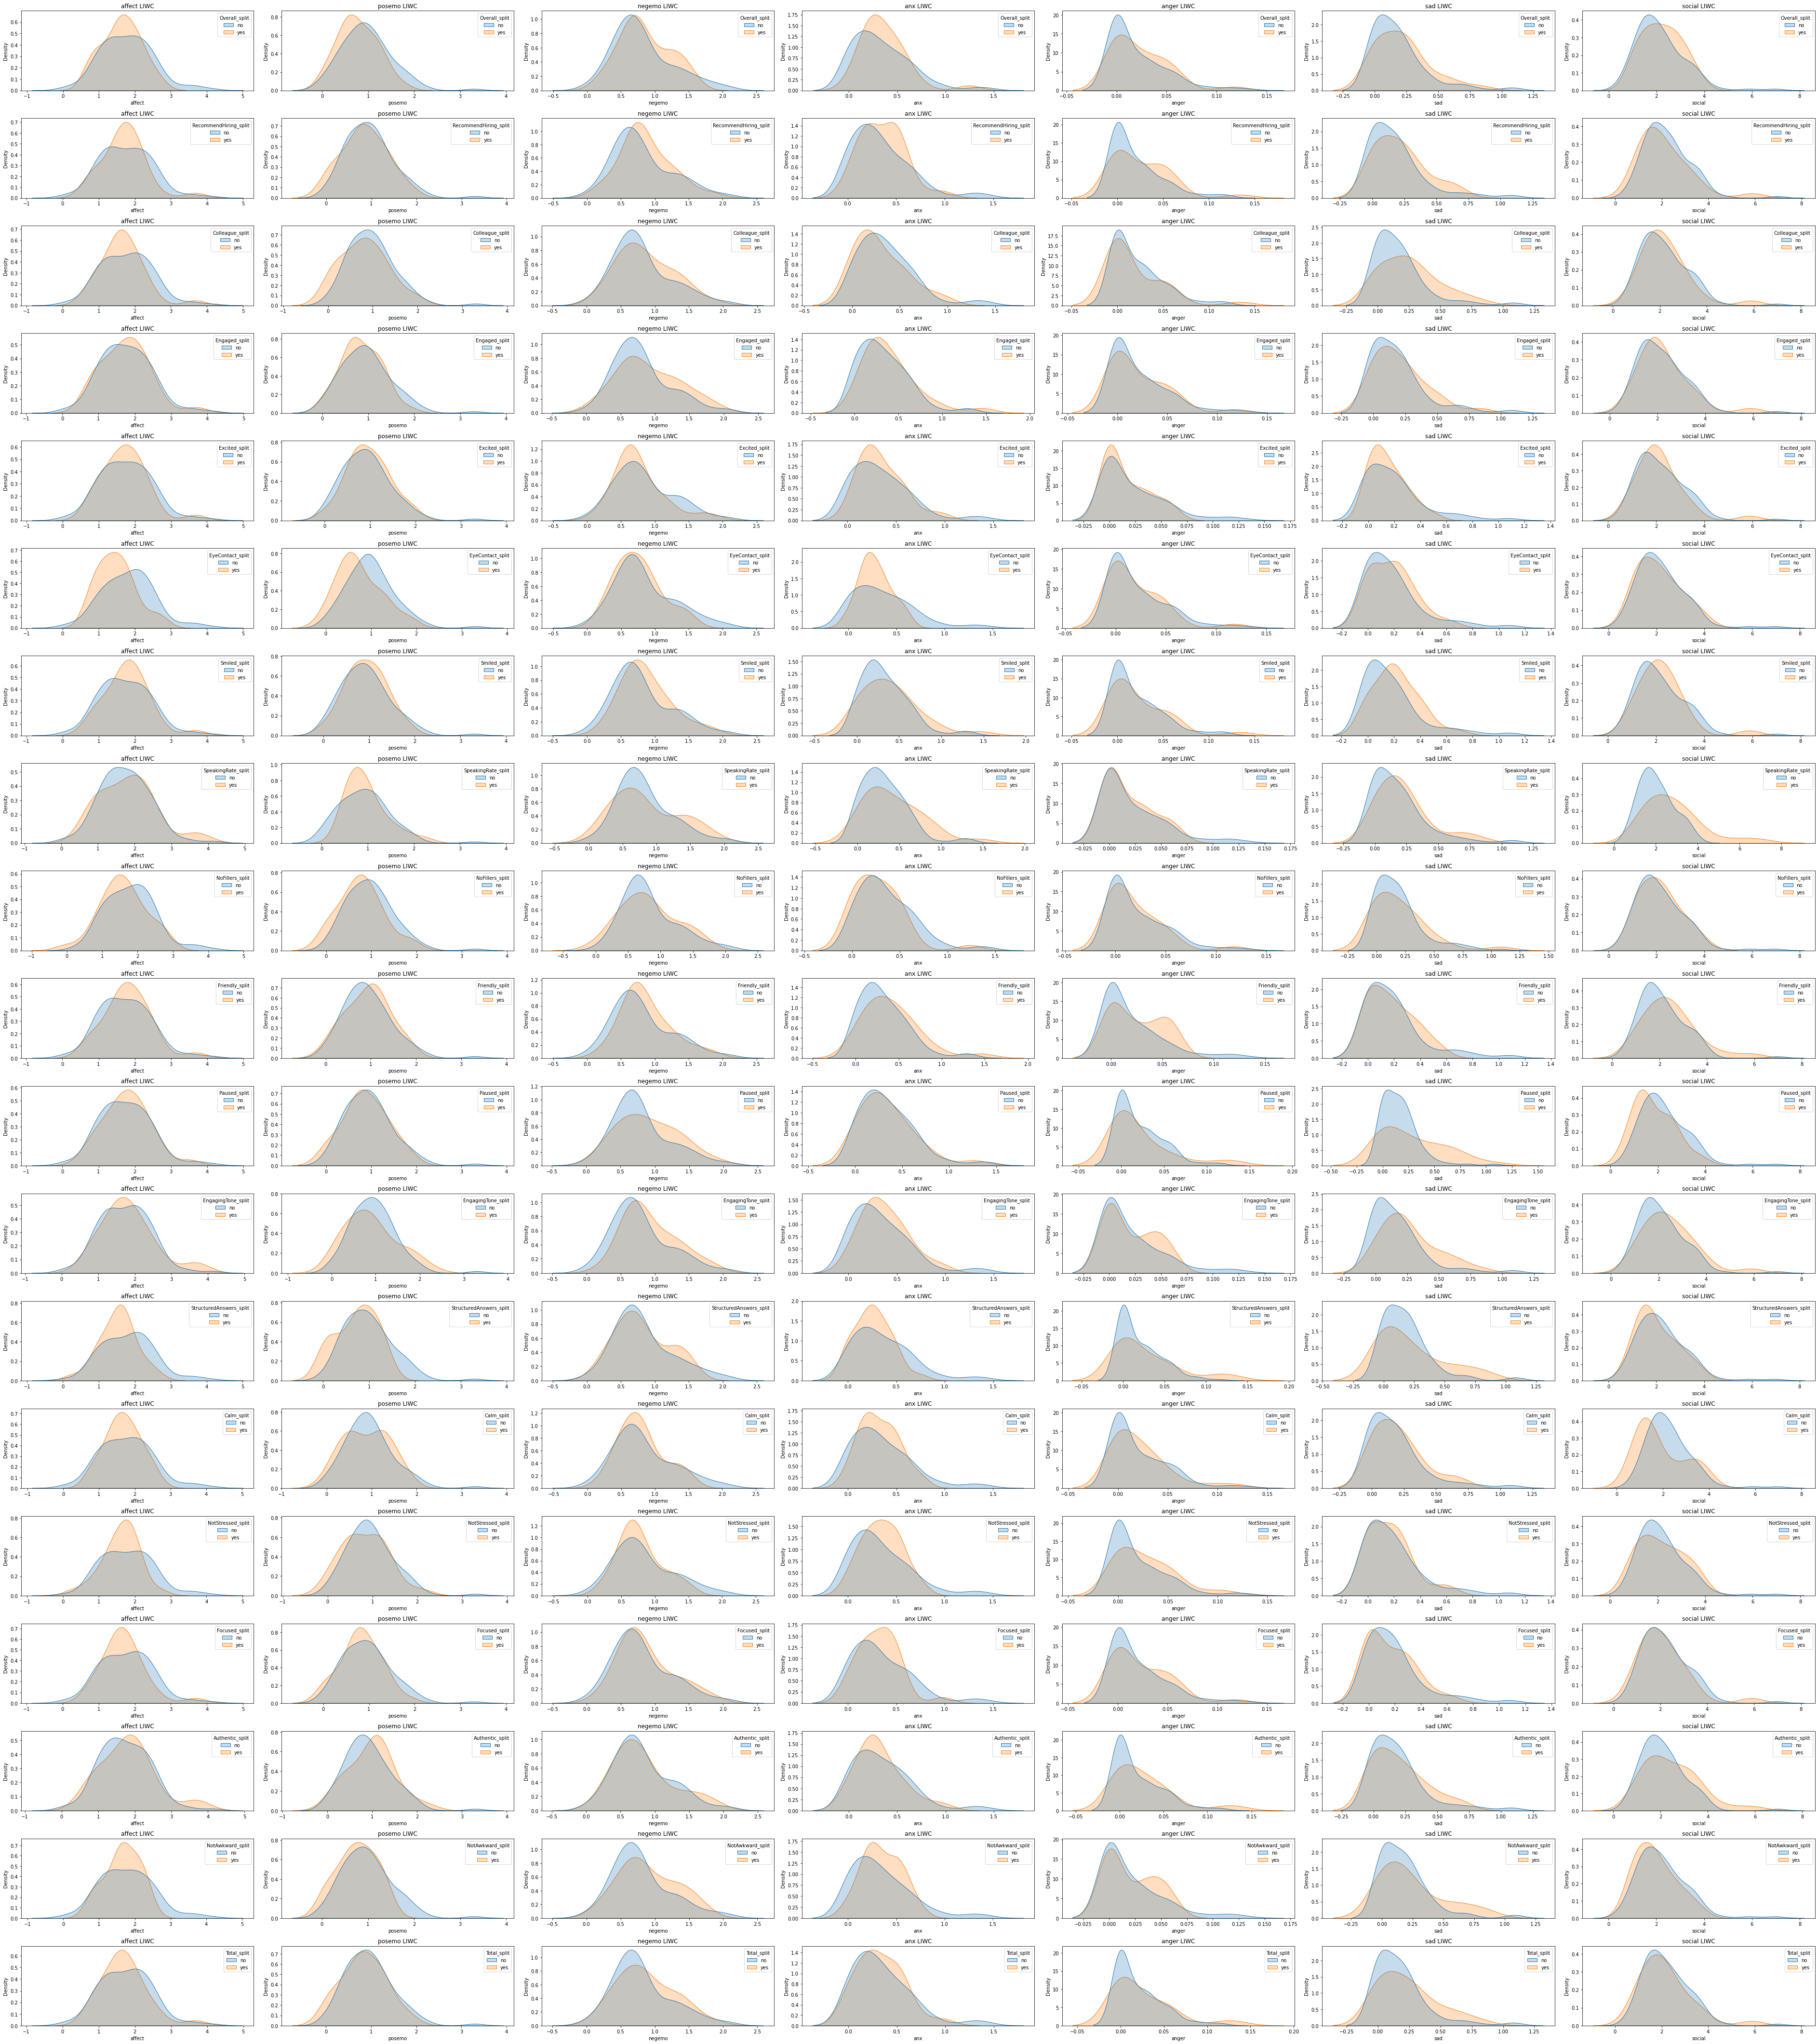

In [ ]:
fig, axes = plt.subplots(len(labels.columns.tolist())-1, len(important), figsize=(7.5 * len(important), 3*len(labels.columns.tolist())-1)) 

for j, feature in enumerate(important):
  for i, label in enumerate(labels.columns.tolist()):
    if label != 'Participant':
      sns.kdeplot(data=df[[f'{label}_split', f'{feature}']], 
                  hue=f'{label}_split', x=f'{feature}', ax=axes[i-1, j], 
                  fill=True, common_norm=False).set(title=f'{feature} LIWC')

plt.tight_layout()

## Save dataframes for dashboard and create figures for all interviews

In [ ]:
df[['Participant','neutral', 'joy', 'anger', 'fear', 'sadness', 'combined_filler_nonflu']].to_csv('drive/MyDrive/Colab Notebooks/XAI/datasets/final_page_analysis.csv', index=False)
mean_stdev.to_csv('drive/MyDrive/Colab Notebooks/XAI/datasets/final_page_mean_stdev.csv')

In [ ]:
def sentiment_graphs(row):
  fig, axes = plt.subplots(3, 2, figsize=(15, 9))
  for name in ['neutral', 'joy', 'anger', 'sadness', 'fear']:
    sns.kdeplot(data=df[[f'{label}_split', f'{name}']], 
                    hue=f'{label}_split', x=f'{name}', ax=axes[y,x], 
                    fill=True, common_norm=False).set(title=f'BERT {name} feature predicts RecommendHirring label') 
    axes[y,x].axvline(stdev_lines(name)[0], color='blue')
    axes[y,x].axvline(stdev_lines(name)[1], color='blue')
    axes[y,x].axvline(row['percentage_prediction'].get(name), color='red')
  # update the axes for figures
  x++
  if x % 2 == 0:
    y++
    x=0

  plt.delaxes(ax=axes[2, 1])
  plt.tight_layout()
  blue_patch = mpatches.Patch(color='blue', label='One standard devation for good interviews')
  red_patch = mpatches.Patch(color='red', label='Your score')
  fig.legend(handles=[blue_patch, red_patch], loc='lower right', fontsize='x-large')
  fig.savefig(f'drive/MyDrive/Colab Notebooks/XAI/graphs/sentiments/{row.Participant}')
  plt.close()

  # simple_features
  fig, axes = plt.subplots(1, 2, figsize=(15, 3))

  # wcps
  name ='wps' 
  label = 'SpeakingRate'
  sns.kdeplot(data=df[[f'{label}_split', f'{name}']], 
                  hue=f'{label}_split', x=f'{name}', ax=axes[0], 
                  fill=True, common_norm=False).set(title=f'Words feature predicts SpeakingRate label') 
  axes[0].axvline(stdev_lines(name)[0], color='blue')
  axes[0].axvline(stdev_lines(name)[1], color='blue')
  axes[0].axvline(row['simple_feature_dict'].get('wps'), color='red')

  # uwcps
  name ='uwps'
  label = 'Paused'
  sns.kdeplot(data=df[[f'{label}_split', f'{name}']], 
                  hue=f'{label}_split', x=f'{name}', ax=axes[1], 
                  fill=True, common_norm=False).set(title=f'Unique words feature predicts Paused label') 
  axes[1].axvline(stdev_lines(name)[0], color='blue')
  axes[1].axvline(stdev_lines(name)[1], color='blue')
  axes[1].axvline(row['simple_feature_dict'].get('uwps'), color='red')

  plt.tight_layout()
  blue_patch = mpatches.Patch(color='blue', label='your score')
  fig.savefig(f'drive/MyDrive/Colab Notebooks/XAI/graphs/simple_features/{row.Participant}')
  plt.close()


  # liwc
  fig, axes = plt.subplots(1, 2, figsize=(15, 3))

  # adj
  name ='adj' 
  label = 'Excited'
  sns.kdeplot(data=df[[f'{label}_split', f'{name}']], 
                  hue=f'{label}_split', x=f'{name}', ax=axes[0], 
                  fill=True, common_norm=False).set(title=f'Adjective LIWC feature predicts Excited label') 
  axes[0].axvline(stdev_lines(name)[0], color='blue')
  axes[0].axvline(stdev_lines(name)[1], color='blue')
  axes[0].axvline(row['adj'], color='red')

  # adverb
  name ='adverb'
  label = 'EngagingTone'
  sns.kdeplot(data=df[[f'{label}_split', f'{name}']], 
                  hue=f'{label}_split', x=f'{name}', ax=axes[1], 
                  fill=True, common_norm=False).set(title=f'Adverb LIWC feature predicts EngagingTone label') 
  axes[1].axvline(stdev_lines(name)[0], color='blue')
  axes[1].axvline(stdev_lines(name)[1], color='blue')
  axes[1].axvline(row['adverb'], color='red')

  plt.tight_layout()
  blue_patch = mpatches.Patch(color='blue', label='your score')
  fig.savefig(f'drive/MyDrive/Colab Notebooks/XAI/graphs/liwc/{row.Participant}')
  plt.close()